# Ensemble Methods on AirBnB

# Faire du voting et du stacking !

Two popular boosting algorithms are Adaboost and XGBoost, the goal of this exercise is to apply them both to a prediction problem and evaluate their performance with different base models. The dataset we will use is that of Airbnb listings in Seattle, the goal is to predict the price per night of the listing.
There will be quite a lot of preprocessing to do in this exercise as well as some interesting exploratory analysis and visualization. Do not hesitate to deviate from the questions to explore the data further.

In [28]:
# !pip install -q xgboost
# !pip install -q s3fs

1. Let's import the usual librairies.

In [92]:
import ast

import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import r2_score
from sklearn.impute import SimpleImputer, KNNImputer

from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, AdaBoostRegressor, VotingRegressor, StackingRegressor, GradientBoostingClassifier, StackingClassifier
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.linear_model import Ridge
from sklearn.svm import SVR
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

2. Import the ```listings.csv``` dataset from s3 using the following link: https://full-stack-bigdata-datasets.s3.eu-west-3.amazonaws.com/Machine+Learning+Supervis%C3%A9/Boosting/listings.csv

In [30]:
dataset = pd.read_csv("https://full-stack-bigdata-datasets.s3.eu-west-3.amazonaws.com/Machine+Learning+Supervis%C3%A9/Boosting/listings.csv")
dataset.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,NaN,NaN,NaN,NaN,https://a1.muscache.com/ac/pictures/67560560/c...,NaN,956883,https://www.airbnb.com/users/show/956883,Maija,2011-08-11,"Seattle, Washington, United States","I am an artist, interior designer, and run a s...",within a few hours,96%,100%,f,https://a0.muscache.com/ac/users/956883/profil...,https://a0.muscache.com/ac/users/956883/profil...,Queen Anne,3.0,3.0,"['email', 'phone', 'reviews', 'kba']",t,t,"Gilman Dr W, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,98119,Seattle,"Seattle, WA",US,United States,47.636289,-122.371025,t,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",NaN,$85.00,NaN,NaN,NaN,NaN,2,$5.00,1,365,4 weeks ago,t,14,41,71,346,2016-01-04,207,2011-11-01,2016-01-02,95.0,10.0,10.0,10.0,10.0,9.0,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",What's up with the free pillows? Our home was...,"Convenient bus stops are just down the block, ...",https://a0.muscache.com/ac/pictures/14409893/f...,https://a0.muscache.com/im/pictures/14409893/f...,https://a0.muscache.com/ac/pictures/14409893/f...,https://a0.muscache.com/ac/pictures/14409893/f...,5177328,https://www.airbnb.com/users/show/5177328,Andrea,2013-02-21,"Seattle, Washington, United States",Living east coast/left coast/overseas. Time i...,within an hour,98%,100%,t,https://a0.muscache.com/ac/users/5177328/profi...,https://a0.muscache.com/ac/users/5177328/profi...,Queen Anne,6.0,6.0,"['email', 'phone', 'facebook', 'linkedin', 're...",t,t,"7th Avenue West, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,98119,Seattle,"Seattle, WA",US,United States,47.639123,-122.365666,t,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",NaN,$150.00,"$1,000.00","$3,000.00",$100.00,$40.00,1,$0.00,2,90,today,t,13,13,16,291,2016-01-04,43,2013-08-19,2015-12-29,96.0,10.0,10.0,10.0,10.0,10.0,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazi

3. There are a lot of columns in this dataset. Display the dataset info.

In [31]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 92 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                3818 non-null   int64  
 1   listing_url                       3818 non-null   object 
 2   scrape_id                         3818 non-null   int64  
 3   last_scraped                      3818 non-null   object 
 4   name                              3818 non-null   object 
 5   summary                           3641 non-null   object 
 6   space                             3249 non-null   object 
 7   description                       3818 non-null   object 
 8   experiences_offered               3818 non-null   object 
 9   neighborhood_overview             2786 non-null   object 
 10  notes                             2212 non-null   object 
 11  transit                           2884 non-null   object 
 12  thumbn

4. Let's proceed to some visualization, first display the distribution of the price variable. You will have to preprocess it as it is not in a numerical format.

In [32]:
dataset["price"].sample(20)

2804     $60.00
2424    $110.00
1073     $41.00
2582     $95.00
626     $150.00
1476     $59.00
832     $145.00
222     $150.00
3807    $109.00
3804    $125.00
3260    $275.00
3526     $27.00
915     $150.00
3005     $95.00
33      $222.00
2978     $90.00
2549    $185.00
1086    $311.00
212      $85.00
1921    $150.00
Name: price, dtype: object

In [33]:
dataset["price"] = dataset["price"].apply(lambda str: str[1:])
dataset["price"].sample(20)

1864    117.00
610      75.00
1600    119.00
3646    195.00
2512     65.00
1816     45.00
2310     52.00
956     150.00
1725    150.00
3656    200.00
2495     60.00
313      40.00
2776     75.00
2297     50.00
1799    225.00
2083    100.00
1456     99.00
1914     90.00
3026    100.00
2927    125.00
Name: price, dtype: object

In [35]:
dataset["price"] = dataset["price"].str.replace(",", "").astype(float)
dataset["price"].sample(20)

3078     89.0
343      55.0
2384     47.0
3418    300.0
1146    100.0
432     490.0
3433     60.0
378      40.0
3056     70.0
443     100.0
1818     90.0
3539     90.0
2373     99.0
3060    140.0
2844    198.0
486     140.0
360      85.0
3611     29.0
1060    149.0
311      40.0
Name: price, dtype: float64

0        $85.00
1       $150.00
2       $975.00
3       $100.00
4       $450.00
         ...   
3813    $359.00
3814     $79.00
3815     $93.00
3816     $99.00
3817     $87.00
Name: price, Length: 3818, dtype: object

In [37]:
fig = px.histogram(dataset["price"], width=800, height=400)
fig.show()


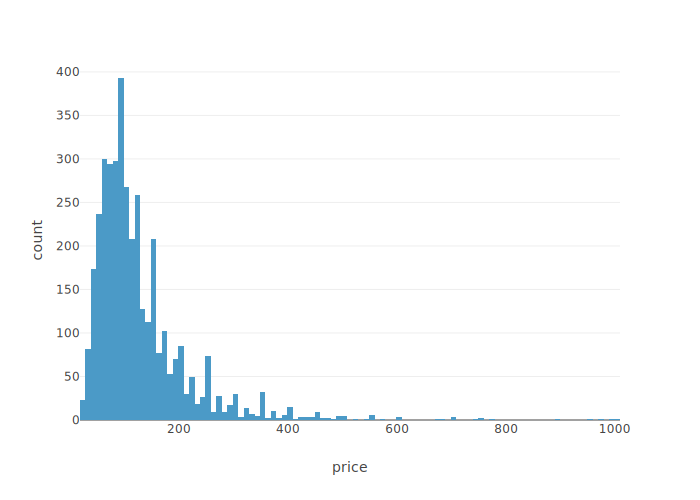

5. The distribution of the target variable is skewed towards high values (this is a very usual situation when working with prices, many items are around the average price range and the higher the price, the fewer items there are). A standard way of working with such variables is to change the scale using the log function so the distribution becomes evenly distributed.
Create a price_log variable that's equal to log(price)

In [38]:
dataset["price_log"] = np.log10(dataset["price"])
dataset.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,price_log
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,NaN,NaN,NaN,NaN,https://a1.muscache.com/ac/pictures/67560560/c...,NaN,956883,https://www.airbnb.com/users/show/956883,Maija,2011-08-11,"Seattle, Washington, United States","I am an artist, interior designer, and run a s...",within a few hours,96%,100%,f,https://a0.muscache.com/ac/users/956883/profil...,https://a0.muscache.com/ac/users/956883/profil...,Queen Anne,3.0,3.0,"['email', 'phone', 'reviews', 'kba']",t,t,"Gilman Dr W, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,98119,Seattle,"Seattle, WA",US,United States,47.636289,-122.371025,t,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",NaN,85.0,NaN,NaN,NaN,NaN,2,$5.00,1,365,4 weeks ago,t,14,41,71,346,2016-01-04,207,2011-11-01,2016-01-02,95.0,10.0,10.0,10.0,10.0,9.0,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07,1.929419
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",What's up with the free pillows? Our home was...,"Convenient bus stops are just down the block, ...",https://a0.muscache.com/ac/pictures/14409893/f...,https://a0.muscache.com/im/pictures/14409893/f...,https://a0.muscache.com/ac/pictures/14409893/f...,https://a0.muscache.com/ac/pictures/14409893/f...,5177328,https://www.airbnb.com/users/show/5177328,Andrea,2013-02-21,"Seattle, Washington, United States",Living east coast/left coast/overseas. Time i...,within an hour,98%,100%,t,https://a0.muscache.com/ac/users/5177328/profi...,https://a0.muscache.com/ac/users/5177328/profi...,Queen Anne,6.0,6.0,"['email', 'phone', 'facebook', 'linkedin', 're...",t,t,"7th Avenue West, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,98119,Seattle,"Seattle, WA",US,United States,47.639123,-122.365666,t,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",NaN,150.0,"$1,000.00","$3,000.00",$100.00,$40.00,1,$0.00,2,90,today,t,13,13,16,291,2016-01-04,43,2013-08-19,2015-12-29,96.0,10.0,10.0,10.0,10.0,10.0,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48,2.176091
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-0

In [40]:
dataset.describe()

,id,scrape_id,host_id,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,square_feet,price,guests_included,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,calculated_host_listings_count,reviews_per_month,price_log
count,3.818000e+03,3.818000e+03,3.818000e+03,3816.000000,3816.000000,3818.000000,3818.000000,3818.000000,3802.000000,3812.000000,3817.000000,97.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3171.000000,3160.000000,3165.000000,3160.000000,3167.000000,3163.000000,3162.000000,0.0,3818.000000,3191.000000,3818.000000
mean,5.550111e+06,2.016010e+13,1.578556e+07,7.157757,7.157757,47.628961,-122.333103,3.349398,1.259469,1.307712,1.735394,854.618557,127.976166,1.672603,2.369303,780.447617,16.786276,36.814825,58.082504,244.772656,22.223415,94.539262,9.636392,9.556398,9.786709,9.809599,9.608916,9.452245,NaN,2.946307,2.078919,2.032163
std,2.962660e+06,0.000000e+00,1.458382e+07,28.628149,28.628149,0.043052,0.031745,1.977599,0.590369,0.883395,1.139480,671.404893,90.250022,1.311040,16.305902,1683.589007,12.173637,23.337541,34.063845,126.772526,37.730892,6.606083,0.698031,0.797274,0.595499,0.568211,0.629053,0.750259,NaN,5.893029,1.822348,0.245605
min,3.335000e+03,2.016010e+13,4.193000e+03,1.000000,1.000000,47.505088,-122.417219,1.000000,0.000000,0.000000,1.000000,0.000000,20.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000,2.000000,3.000000,2.000000,2.000000,4.000000,2.000000,NaN,1.000000,0.020000,1.301030
25%,3.258256e+06,2.016010e+13,3.275204e+06,1.000000,1.000000,47.609418,-122.354320,2.000000,1.000000,1.000000,1.000000,420.000000,75.000000,1.000000,1.000000,60.000000,2.000000,13.000000,28.000000,124.000000,2.000000,93.000000,9.000000,9.000000,10.000000,10.000000,9.000000,9.000000,NaN,1.000000,0.695000,1.875061
50%,6.118244e+06,2.016010e+13,1.055814e+07,1.000000,1.000000,47.623601,-122.328874,3.000000,1.000000,1.000000,1.000000,750.000000,100.000000,1.000000,2.000000,1125.000000,20.000000,46.000000,73.000000,308.000000,9.000000,96.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,1.000000,1.540000,2.000000
75%,8.035127e+06,2.016010e+13,2.590309e+07,3.000000,3.000000,47.662694,-122.310800,4.000000,1.000000,2.000000,2.000000,1200.000000,150.000000,2.000000,2.000000,1125.000000,30.000000,59.000000,89.000000,360.000000,26.000000,99.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,2.000000,3.000000,2.176091
max,1.034016e+07,2.016010e+13,5.320861e+07,502.000000,502.000000,47.733358,-122.240607,16.000000,8.000000,7.000000,15.000000,3000.000000,1000.000000,15.000000,1000.000000,100000.000000,30.000000,60.000000,90.000000,365.000000,474.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,37.000000,12.150000,3.000000


,id,scrape_id,host_id,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,square_feet,price,guests_included,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,calculated_host_listings_count,reviews_per_month,price_log
count,3.818000e+03,3.818000e+03,3.818000e+03,3816.000000,3816.000000,3818.000000,3818.000000,3818.000000,3802.000000,3812.000000,3817.000000,97.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3171.000000,3160.000000,3165.000000,3160.000000,3167.000000,3163.000000,3162.000000,0.0,3818.000000,3191.000000,3818.000000
mean,5.550111e+06,2.016010e+13,1.578556e+07,7.157757,7.157757,47.628961,-122.333103,3.349398,1.259469,1.307712,1.735394,854.618557,127.976166,1.672603,2.369303,780.447617,16.786276,36.814825,58.082504,244.772656,22.223415,94.539262,9.636392,9.556398,9.786709,9.809599,9.608916,9.452245,NaN,2.946307,2.078919,2.032163
std,2.962660e+06,0.000000e+00,1.458382e+07,28.628149,28.628149,0.043052,0.031745,1.977599,0.590369,0.883395,1.139480,671.404893,90.250022,1.311040,16.305902,1683.589007,12.173637,23.337541,34.063845,126.772526,37.730892,6.606083,0.698031,0.797274,0.595499,0.568211,0.629053,0.750259,NaN,5.893029,1.822348,0.245605
min,3.335000e+03,2.016010e+13,4.193000e+03,1.000000,1.000000,47.505088,-122.417219,1.000000,0.000000,0.000000,1.000000,0.000000,20.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000,2.000000,3.000000,2.000000,2.000000,4.000000,2.000000,NaN,1.000000,0.020000,1.301030
25%,3.258256e+06,2.016010e+13,3.275204e+06,1.000000,1.000000,47.609418,-122.354320,2.000000,1.000000,1.000000,1.000000,420.000000,75.000000,1.000000,1.000000,60.000000,2.000000,13.000000,28.000000,124.000000,2.000000,93.000000,9.000000,9.000000,10.000000,10.000000,9.000000,9.000000,NaN,1.000000,0.695000,1.875061
50%,6.118244e+06,2.016010e+13,1.055814e+07,1.000000,1.000000,47.623601,-122.328874,3.000000,1.000000,1.000000,1.000000,750.000000,100.000000,1.000000,2.000000,1125.000000,20.000000,46.000000,73.000000,308.000000,9.000000,96.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,1.000000,1.540000,2.000000
75%,8.035127e+06,2.016010e+13,2.590309e+07,3.000000,3.000000,47.662694,-122.310800,4.000000,1.000000,2.000000,2.000000,1200.000000,150.000000,2.000000,2.000000,1125.000000,30.000000,59.000000,89.000000,360.000000,26.000000,99.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,2.000000,3.000000,2.176091
max,1.034016e+07,2.016010e+13,5.320861e+07,502.000000,502.000000,47.733358,-122.240607,16.000000,8.000000,7.000000,15.000000,3000.000000,1000.000000,15.000000,1000.000000,100000.000000,30.000000,60.000000,90.000000,365.000000,474.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,37.000000,12.150000,3.000000


In [41]:
fig = px.histogram(dataset["price_log"], width=800, height=400)
fig.show()


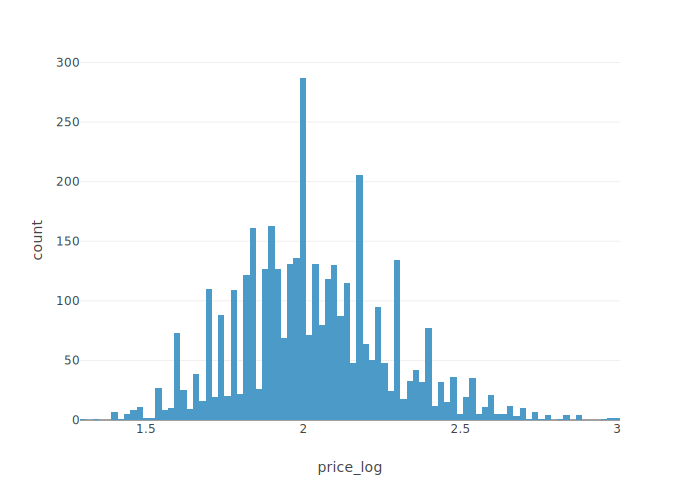

The distribution looks a lot better for prediction purposes after the log transformation!

6. Visualize the price against the following variables : 

- ```room type```
- ```beds```
- ```property type```

In [42]:
fig = px.box(dataset, x = "room_type", y="price_log" )
fig.show()


In [43]:
fig = px.box(dataset, x = "beds", y="price_log" )
fig.show()


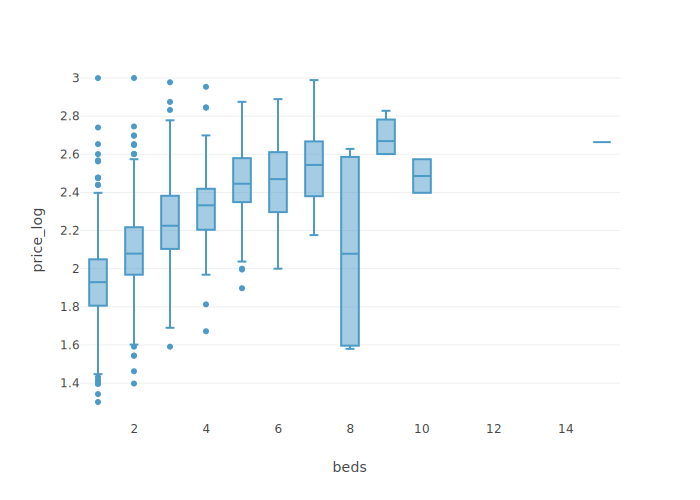

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,price_log
935,7344117,https://www.airbnb.com/rooms/7344117,20160104002432,2016-01-04,"SUPER TALL, 5-Level Loft, 2200sf","5-level, bright & modern loft with 20' ceiling...",Welcome to my 5-story loft located about a lit...,"5-level, bright & modern loft with 20' ceiling...",none,We are located at 1820 E Yesler Way in Seattle...,There is one compact parking space available i...,"Yep, Seattle is hilly. No worries - the #27 Me...",https://a1.muscache.com/ac/pictures/93184318/2...,https://a1.muscache.com/im/pictures/93184318/2...,https://a1.muscache.com/ac/pictures/93184318/2...,https://a1.muscache.com/ac/pictures/93184318/2...,38474213,https://www.airbnb.com/users/show/38474213,Jessie,2015-07-14,"Seattle, Washington, United States",NaN,within an hour,92%,100%,t,https://a0.muscache.com/ac/users/38474213/prof...,https://a0.muscache.com/ac/users/38474213/prof...,Minor,1.0,1.0,"['email', 'phone', 'linkedin', 'reviews', 'jum...",t,t,"East Yesler Way, Seattle, WA 98122, United States",Minor,Minor,Central Area,Seattle,WA,98122,Seattle,"Seattle, WA",US,United States,47.602301,-122.307173,t,Loft,Entire home/apt,10,2.5,2.0,8.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",NaN,425.0,NaN,NaN,NaN,$85.00,4,$25.00,1,1125,today,t,21,49,78,188,2016-01-04,32,2015-07-20,2015-12-30,96.0,10.0,10.0,10.0,10.0,9.0,10.0,f,NaN,WASHINGTON,t,strict,f,f,1,5.68,2.628389
997,8424532,https://www.airbnb.com/rooms/8424532,20160104002432,2016-01-04,Ideal Home for Small Reunions,Lge home- corner lot -walking distance to Lak...,NaN,Lge home- corner lot -walking distance to Lak...,none,NaN,NaN,NaN,https://a0.muscache.com/ac/pictures/107150138/...,https://a0.muscache.com/im/pictures/107150138/...,https://a0.muscache.com/ac/pictures/107150138/...,https://a0.muscache.com/ac/pictures/107150138/...,658155,https://www.airbnb.com/users/show/658155,Joe,2011-06-02,"Seattle, Washington, United States",Addicted renovator of homes. Love helping peo...,within an hour,100%,100%,t,https://a2.muscache.com/ac/users/658155/profil...,https://a2.muscache.com/ac/users/658155/profil...,Capitol Hill,13.0,13.0,"['email', 'phone', 'reviews', 'kba']",t,t,"32nd Avenue, Seattle, WA 98122, United States",Leschi,Leschi,Central Area,Seattle,WA,98122,Seattle,"Seattle, WA",US,United States,47.604379,-122.291115,t,House,Entire home/apt,12,3.5,5.0,8.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",NaN,350.0,NaN,NaN,$500.00,$250.00,1,$0.00,7,1125,today,t,18,40,70,292,2016-01-04,2,2015-10-08,2015-10-30,100.0,10.0,10.0,10.0,10.0,10.0,10.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.67,2.544068
1069,6119821,https://ww

In [44]:
fig = px.box(dataset, x = "property_type", y="price_log" )
fig.show()


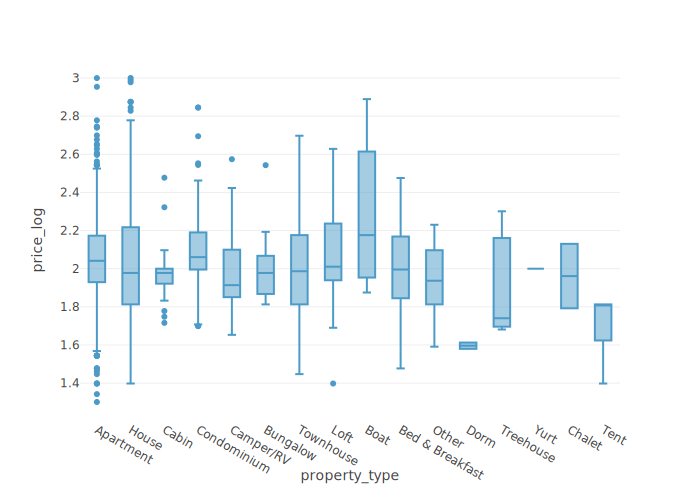

7. Isolate the target variable in an object y and the other variables in an object X

In [45]:
target_name = "price_log"
X = dataset.drop(target_name, axis = 1)
X = dataset.drop("price", axis = 1)
y = dataset.loc[:,target_name]


8. We will have to remove a certain number of variables that we do not know how to use at this point. Start by removing the variables that could be interpreted as an ```id``` , we will also remove the variables that contain long texts as we haven't learned about text processing yet. 

We also have to remove all variables related to price, as they represent a risk of leak because of their direct link to the target variable, like ```monthly price```.

A certain number of variables contain a very high amount of missing values, in some cases these missing values correspond to an information we can exploit, sometimes not. Remove these not so useful variables from the dataset, strat by checking the proportion of missing values for all variables.

Your dataset should only contain categorical and numerical variables after this step. Check if your final dataset contains the following variables :

```
Index(['host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_listings_count',
       'host_total_listings_count', 'host_has_profile_pic',
       'host_identity_verified', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bedrooms', 'beds', 'bed_type', 'security_deposit', 'cleaning_fee',
       'guests_included', 'extra_people', 'minimum_nights', 'maximum_nights',
       'has_availability', 'availability_30', 'availability_60',
       'availability_90', 'availability_365', 'number_of_reviews',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'requires_license', 'instant_bookable',
       'cancellation_policy', 'require_guest_profile_picture',
       'require_guest_phone_verification', 'calculated_host_listings_count',
       'reviews_per_month'],
      dtype='object')
```

In [46]:
a = X.isnull().sum()/X.shape[0]*100
a.sort_values(ascending=False)

license                             100.000000
square_feet                          97.459403
monthly_price                        60.267156
security_deposit                     51.126244
weekly_price                         47.380828
notes                                42.063908
neighborhood_overview                27.029859
cleaning_fee                         26.977475
transit                              24.463070
host_about                           22.498690
host_acceptance_rate                 20.246202
review_scores_checkin                17.234154
review_scores_accuracy               17.234154
review_scores_value                  17.181771
review_scores_location               17.155579
review_scores_cleanliness            17.103195
review_scores_communication          17.050812
review_scores_rating                 16.946045
reviews_per_month                    16.422211
first_review                         16.422211
last_review                          16.422211
space        

Rate of missing values:


license                             100.000000
square_feet                          97.459403
monthly_price                        60.267156
security_deposit                     51.126244
weekly_price                         47.380828
notes                                42.063908
neighborhood_overview                27.029859
cleaning_fee                         26.977475
transit                              24.463070
host_about                           22.498690
host_acceptance_rate                 20.246202
review_scores_accuracy               17.234154
review_scores_checkin                17.234154
review_scores_value                  17.181771
review_scores_location               17.155579
review_scores_cleanliness            17.103195
review_scores_communication          17.050812
review_scores_rating                 16.946045
last_review                          16.422211
first_review                         16.422211
reviews_per_month                    16.422211
space        

In [47]:
X_clean = X.drop(["host_location", 
                  "experiences_offered",
                  "host_about", 
                  "host_thumbnail_url",
                  "host_picture_url",
                  "license",
                  "monthly_price",
                  "square_feet",
                  "street", 
                  "neighbourhood", 
                  "neighbourhood_cleansed", 
                  "city", 
                  "state", 
                  "market", 
                  "smart_location",
                  "country_code",
                  "country",
                  "amenities",
                  "jurisdiction_names",
                  "first_review",
                  "last_review",
                  "calendar_last_scraped",
                  "weekly_price",
                  "notes",
                  "neighborhood_overview",
                  "name",
                  "description",
                  "listing_url" ,
                  "host_id",
                  "host_url",
                  "scrape_id",
                  "space",
                  "picture_url",
                  "last_scraped",
                  "host_name",
                  "medium_url",
                  "summary",
                  "xl_picture_url",
                  "transit",
                  "thumbnail_url",
                  "host_neighbourhood",
                  "zipcode",
                  "calendar_updated",
                  "license",
                  "id"], axis=1)

9. Are there any remaining missing values ? Is there a relevant way to replace those missing values without using imputing methods ? Are all the variables in a numerical format ? If not run some preprocessing to create a clean dataset.

Remaining missing values:


security_deposit                    51.126244
cleaning_fee                        26.977475
host_acceptance_rate                20.246202
review_scores_checkin               17.234154
review_scores_accuracy              17.234154
review_scores_value                 17.181771
review_scores_location              17.155579
review_scores_cleanliness           17.103195
review_scores_communication         17.050812
review_scores_rating                16.946045
reviews_per_month                   16.422211
host_response_rate                  13.698271
host_response_time                  13.698271
bathrooms                            0.419068
bedrooms                             0.157150
host_since                           0.052383
host_is_superhost                    0.052383
host_listings_count                  0.052383
host_total_listings_count            0.052383
host_has_profile_pic                 0.052383
host_identity_verified               0.052383
property_type                     

In [48]:
a = X_clean.isnull().sum()/X.shape[0]*100
a.sort_values(ascending=False)

security_deposit                    51.126244
cleaning_fee                        26.977475
host_acceptance_rate                20.246202
review_scores_accuracy              17.234154
review_scores_checkin               17.234154
review_scores_value                 17.181771
review_scores_location              17.155579
review_scores_cleanliness           17.103195
review_scores_communication         17.050812
review_scores_rating                16.946045
reviews_per_month                   16.422211
host_response_rate                  13.698271
host_response_time                  13.698271
bathrooms                            0.419068
bedrooms                             0.157150
host_since                           0.052383
host_identity_verified               0.052383
host_has_profile_pic                 0.052383
host_verifications                   0.052383
host_total_listings_count            0.052383
host_listings_count                  0.052383
host_is_superhost                 

In [49]:
print('Processing cleaning fee...')
print(X['cleaning_fee'].head())
X_clean['cleaning_fee'] = X_clean['cleaning_fee'].apply(lambda x: float(x[1:]) if type(x) == str else x)
X_clean['cleaning_fee'] = X_clean['cleaning_fee'].fillna(0)
print(X_clean['cleaning_fee'].head())

0        NaN
1     $40.00
2    $300.00
3        NaN
4    $125.00
Name: cleaning_fee, dtype: object
0      0.0
1     40.0
2    300.0
3      0.0
4    125.0
Name: cleaning_fee, dtype: float64


Processing cleaning fee...
0        NaN
1     $40.00
2    $300.00
3        NaN
4    $125.00
Name: cleaning_fee, dtype: object
Done.
0      0.0
1     40.0
2    300.0
3      0.0
4    125.0
Name: cleaning_fee, dtype: float64


In [52]:
print('Processing host_response_rate...')
print(X_clean['host_response_rate'].head())
X_clean["host_response_rate"] = X_clean['host_response_rate'].apply(
    lambda x: float(x[:-1])/100 if type(x) == str else x)

print(X_clean['host_response_rate'].head())

Processing host_response_rate...
0    0.96
1    0.98
2    0.67
3     NaN
4    1.00
Name: host_response_rate, dtype: float64
0    0.96
1    0.98
2    0.67
3     NaN
4    1.00
Name: host_response_rate, dtype: float64


Processing host_response_rate...
0     96%
1     98%
2     67%
3     NaN
4    100%
Name: host_response_rate, dtype: object
Done.
0    0.96
1    0.98
2    0.67
3     NaN
4    1.00
Name: host_response_rate, dtype: float64


In [51]:
print('Processing host_acceptance_rate...')
print(X_clean['host_acceptance_rate'].head())
X_clean["host_acceptance_rate"] = X_clean["host_acceptance_rate"].apply(lambda x: int(x[:-1])/100 if type(x) == str else x)
print(X_clean['host_acceptance_rate'].head())

Processing host_acceptance_rate...
0    100%
1    100%
2    100%
3     NaN
4     NaN
Name: host_acceptance_rate, dtype: object
0    1.0
1    1.0
2    1.0
3    NaN
4    NaN
Name: host_acceptance_rate, dtype: float64


Processing host_acceptance_rate...
0    100%
1    100%
2    100%
3     NaN
4     NaN
Name: host_acceptance_rate, dtype: object
Done.
0    1.0
1    1.0
2    1.0
3    NaN
4    NaN
Name: host_acceptance_rate, dtype: float64


In [53]:
print('Processing security_deposit...')
print(X_clean['security_deposit'].head())
X_clean['security_deposit'] = X_clean['security_deposit'].apply(lambda x: float(str(x).replace(",","").replace("nan","$0")[1:]))
X_clean['security_deposit'] = X_clean['security_deposit'].fillna(0)
print('Done.')
print(X_clean['security_deposit'].head())

Processing security_deposit...
0          NaN
1      $100.00
2    $1,000.00
3          NaN
4      $700.00
Name: security_deposit, dtype: object
Done.
0       0.0
1     100.0
2    1000.0
3       0.0
4     700.0
Name: security_deposit, dtype: float64


Processing security_deposit...
0          NaN
1      $100.00
2    $1,000.00
3          NaN
4      $700.00
Name: security_deposit, dtype: object
Done.
0       0.0
1     100.0
2    1000.0
3       0.0
4     700.0
Name: security_deposit, dtype: float64


In [54]:
print('Processing host_has_profile_pic...')
print(X_clean['host_has_profile_pic'].head())
X_clean['host_has_profile_pic'] = X_clean['host_has_profile_pic'].fillna("f")
print('Done.')
print(X_clean['host_has_profile_pic'].head())

Processing host_has_profile_pic...
0    t
1    t
2    t
3    t
4    t
Name: host_has_profile_pic, dtype: object
Done.
0    t
1    t
2    t
3    t
4    t
Name: host_has_profile_pic, dtype: object


Processing host_has_profile_pic...
0    t
1    t
2    t
3    t
4    t
Name: host_has_profile_pic, dtype: object
Done.
0    t
1    t
2    t
3    t
4    t
Name: host_has_profile_pic, dtype: object


In [55]:
print('Processing host_identity_verified...')
print(X_clean['host_identity_verified'].head())
X_clean.host_identity_verified = X_clean.host_identity_verified.fillna("f")
print('Done.')
print(X_clean['host_identity_verified'].head())

Processing host_identity_verified...
0    t
1    t
2    t
3    t
4    t
Name: host_identity_verified, dtype: object
Done.
0    t
1    t
2    t
3    t
4    t
Name: host_identity_verified, dtype: object


Processing host_identity_verified...
0    t
1    t
2    t
3    t
4    t
Name: host_identity_verified, dtype: object
Done.
0    t
1    t
2    t
3    t
4    t
Name: host_identity_verified, dtype: object


In [56]:
print('Processing is_location_exact...')
print(X_clean['is_location_exact'].head())
X_clean['is_location_exact'] = X_clean['is_location_exact'].fillna("f")
print('Done.')
print(X_clean['is_location_exact'].head())

Processing is_location_exact...
0    t
1    t
2    t
3    t
4    t
Name: is_location_exact, dtype: object
Done.
0    t
1    t
2    t
3    t
4    t
Name: is_location_exact, dtype: object


Processing is_location_exact...
0    t
1    t
2    t
3    t
4    t
Name: is_location_exact, dtype: object
Done.
0    t
1    t
2    t
3    t
4    t
Name: is_location_exact, dtype: object


In [57]:
print('Processing host_response_time...')
print(X_clean['host_response_time'].head())
X_clean['host_response_time'] = X_clean['host_response_time'].fillna("unknown")
print('Done.')
print(X_clean['host_response_time'].head())

Processing host_response_time...
0    within a few hours
1        within an hour
2    within a few hours
3                   NaN
4        within an hour
Name: host_response_time, dtype: object
Done.
0    within a few hours
1        within an hour
2    within a few hours
3               unknown
4        within an hour
Name: host_response_time, dtype: object


Processing host_response_time...
0    within a few hours
1        within an hour
2    within a few hours
3                   NaN
4        within an hour
Name: host_response_time, dtype: object
Done.
0    within a few hours
1        within an hour
2    within a few hours
3               unknown
4        within an hour
Name: host_response_time, dtype: object


In [58]:
print('Processing host_is_superhost...')
print(X_clean['host_is_superhost'].head())
X_clean['host_is_superhost'] = X_clean['host_is_superhost'].fillna("unknown")
print('Done.')
print(X_clean['host_is_superhost'].head())

Processing host_is_superhost...
0    f
1    t
2    f
3    f
4    f
Name: host_is_superhost, dtype: object
Done.
0    f
1    t
2    f
3    f
4    f
Name: host_is_superhost, dtype: object


Processing host_is_superhost...
0    f
1    t
2    f
3    f
4    f
Name: host_is_superhost, dtype: object
Done.
0    f
1    t
2    f
3    f
4    f
Name: host_is_superhost, dtype: object


In [59]:
print('Processing property_type...')
print(X_clean['property_type'].head())
X_clean['property_type'] = X_clean['property_type'].fillna("unknown")
print('Done.')
print(X_clean['property_type'].head())

Processing property_type...
0    Apartment
1    Apartment
2        House
3    Apartment
4        House
Name: property_type, dtype: object
Done.
0    Apartment
1    Apartment
2        House
3    Apartment
4        House
Name: property_type, dtype: object


Processing property_type...
0    Apartment
1    Apartment
2        House
3    Apartment
4        House
Name: property_type, dtype: object
Done.
0    Apartment
1    Apartment
2        House
3    Apartment
4        House
Name: property_type, dtype: object


In [60]:
print('Processing extra_people...')
print(X_clean['extra_people'].head())
X_clean['extra_people'] = X_clean['extra_people'].apply(lambda x: float(x[1:]))
print('Done.')
print(X_clean['extra_people'].head())

Processing extra_people...
0     $5.00
1     $0.00
2    $25.00
3     $0.00
4    $15.00
Name: extra_people, dtype: object
Done.
0     5.0
1     0.0
2    25.0
3     0.0
4    15.0
Name: extra_people, dtype: float64


Processing extra_people...
0     $5.00
1     $0.00
2    $25.00
3     $0.00
4    $15.00
Name: extra_people, dtype: object
Done.
0     5.0
1     0.0
2    25.0
3     0.0
4    15.0
Name: extra_people, dtype: float64


In [63]:
print('Processing host_verifications...')
print(X_clean['host_verifications'].head())
X_clean["host_verifications"] = X_clean['host_verifications'].fillna("[]")
X_clean["host_verifications"] = X_clean["host_verifications"].apply(lambda x : x.replace("None","[]"))
X_clean["host_verifications"] = X_clean["host_verifications"].apply(lambda x: len(ast.literal_eval(x)))
print('Done.')
print(X_clean['host_verifications'].head())

Processing host_verifications...
0                 ['email', 'phone', 'reviews', 'kba']
1    ['email', 'phone', 'facebook', 'linkedin', 're...
2     ['email', 'phone', 'google', 'reviews', 'jumio']
3    ['email', 'phone', 'facebook', 'reviews', 'jum...
4     ['email', 'phone', 'facebook', 'reviews', 'kba']
Name: host_verifications, dtype: object
Done.
0    4
1    6
2    5
3    5
4    5
Name: host_verifications, dtype: int64


Processing host_verifications...
0                 ['email', 'phone', 'reviews', 'kba']
1    ['email', 'phone', 'facebook', 'linkedin', 're...
2     ['email', 'phone', 'google', 'reviews', 'jumio']
3    ['email', 'phone', 'facebook', 'reviews', 'jum...
4     ['email', 'phone', 'facebook', 'reviews', 'kba']
Name: host_verifications, dtype: object
Done.
0    4
1    6
2    5
3    5
4    5
Name: host_verifications, dtype: int64


In [64]:
print('Processing host_since...')
print(X_clean['host_since'].head())
X_clean['host_since'] = (pd.Timestamp("today") - pd.to_datetime(X_clean['host_since'], format= "%Y-%m-%d"))
X_clean['host_since'] = X_clean['host_since'].apply(lambda x: x.days)
print('Done.')
print(X_clean['host_since'].head())

Processing host_since...
0    2011-08-11
1    2013-02-21
2    2014-06-12
3    2013-11-06
4    2011-11-29
Name: host_since, dtype: object
Done.
0    4633.0
1    4073.0
2    3597.0
3    3815.0
4    4523.0
Name: host_since, dtype: float64


Processing host_since...
0    2011-08-11
1    2013-02-21
2    2014-06-12
3    2013-11-06
4    2011-11-29
Name: host_since, dtype: object
Done.
0    3990.0
1    3430.0
2    2954.0
3    3172.0
4    3880.0
Name: host_since, dtype: float64


10. Check that all variables that can can be converted are in numerical format, do not forget to check y as well.

In [65]:
X_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 48 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   host_since                        3816 non-null   float64
 1   host_response_time                3818 non-null   object 
 2   host_response_rate                3295 non-null   float64
 3   host_acceptance_rate              3045 non-null   float64
 4   host_is_superhost                 3818 non-null   object 
 5   host_listings_count               3816 non-null   float64
 6   host_total_listings_count         3816 non-null   float64
 7   host_verifications                3818 non-null   int64  
 8   host_has_profile_pic              3818 non-null   object 
 9   host_identity_verified            3818 non-null   object 
 10  neighbourhood_group_cleansed      3818 non-null   object 
 11  latitude                          3818 non-null   float64
 12  longit

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 47 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   host_since                        3816 non-null   float64
 1   host_response_time                3818 non-null   object 
 2   host_response_rate                3295 non-null   float64
 3   host_acceptance_rate              3045 non-null   float64
 4   host_is_superhost                 3818 non-null   object 
 5   host_listings_count               3816 non-null   float64
 6   host_total_listings_count         3816 non-null   float64
 7   host_verifications                3818 non-null   int64  
 8   host_has_profile_pic              3818 non-null   object 
 9   host_identity_verified            3818 non-null   object 
 10  neighbourhood_group_cleansed      3818 non-null   object 
 11  latitude                          3818 non-null   float64
 12  longit

11. Apply ```train_test_split``` to create an X_train X_test y_train and y_test objects. (with random_state = 1)

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X_clean, y, test_size =0.2, random_state = 1)

12. Separate the variables into two groups, one for the numerical variables and one for the categorical variables. And apply preprocessings to each subgroup of variables properly.

In [68]:
numeric_features = X_clean.select_dtypes(include="number").columns
categorical_features = X_clean.select_dtypes(exclude="number").columns

print(numeric_features)
print(categorical_features)


Index(['host_since', 'host_response_rate', 'host_acceptance_rate', 'host_listings_count', 'host_total_listings_count', 'host_verifications', 'latitude', 'longitude', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'security_deposit', 'cleaning_fee', 'guests_included', 'extra_people', 'minimum_nights', 'maximum_nights', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'calculated_host_listings_count', 'reviews_per_month', 'price_log'], dtype='object')
Index(['host_response_time', 'host_is_superhost', 'host_has_profile_pic', 'host_identity_verified', 'neighbourhood_group_cleansed', 'is_location_exact', 'property_type', 'room_type', 'bed_type', 'has_availability', 'requires_license', 'instant_bookable', 'cancellation_policy', 'require_guest_profile_picture', 

In [69]:
# Create pipeline for numeric features
numeric_transformer = Pipeline(steps=[
    ('imputer', KNNImputer()),
    ('scaler', StandardScaler())
])

# Create pipeline for categorical features
categorical_transformer = Pipeline(
    steps=[
    ('imputer', SimpleImputer(strategy = 'most_frequent')),
    ('encoder', OneHotEncoder())
    ])

# Use ColumnTranformer to make a preprocessor object that describes all the treatments to be done
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Preprocessings on train set
X_train = preprocessor.fit_transform(X_train)

# Preprocessings on test set
X_test = preprocessor.transform(X_test) # Don't fit again !!


Found numeric features  ['host_since', 'host_response_rate', 'host_acceptance_rate', 'host_listings_count', 'host_total_listings_count', 'host_verifications', 'latitude', 'longitude', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'security_deposit', 'cleaning_fee', 'guests_included', 'extra_people', 'minimum_nights', 'maximum_nights', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'calculated_host_listings_count', 'reviews_per_month']
Found categorical features  ['host_response_time', 'host_is_superhost', 'host_has_profile_pic', 'host_identity_verified', 'neighbourhood_group_cleansed', 'is_location_exact', 'property_type', 'room_type', 'bed_type', 'has_availability', 'requires_license', 'instant_bookable', 'cancellation_policy', 'require_guest_profile_

13. What score would you expect for a model that would always predict the average price?

In [72]:
baseline_train = np.ones_like(y_train) * y_train.mean()
baseline_test = np.ones_like(y_test) * y_train.mean()
print(f"R2 baseline train {r2_score(y_train, baseline_train)}")
print(f"R2 baseline test {r2_score(y_test, baseline_test)}")

R2 baseline train 0.0
R2 baseline test -0.00014016020168972076


R2 baseline train 0.0
R2 baseline test -0.00014016020169149712


14. Train an Adaboost model with all its default parameters, what's the score ?


In [75]:
regressor_ada = AdaBoostRegressor()
regressor_ada.fit(X_train, y_train)

print(f"R2 Adaboost default train {regressor_ada.score(X_train, y_train)}")
print(f"R2 Adaboost default test  {regressor_ada.score(X_test, y_test)}")

R2 Adaboost default train 0.9957724356869915
R2 Adaboost default test  0.9954244505899444


15. Train an XGBoost model with all its default parameters except max_depth=3 (the same as adaboost default), what's the score ?

In [77]:
regressor_xgb = XGBRegressor(max_depth=3)
regressor_xgb.fit(X_train, y_train)

print("R2 XGBoost default train {}".format(regressor_xgb.score(X_train, y_train)))
print("R2 XGBoost default test {}".format(regressor_xgb.score(X_test, y_test)))

R2 XGBoost default train 0.9999186362772702
R2 XGBoost default test 0.9998474052393209


R2 XGBoost default train 0.866199262674102
R2 XGBoost default test 0.756313204762493


16. Adaboost does not seem to be performing as well as XGBoost, however it does not seem to overfit the data as much, try and improve it by playing with its parameters ```learning rate``` & ```n_estimators``` thanks to a grid search

In [79]:
# Perform grid search
print("Grid search...")
model = AdaBoostRegressor()

# Grid of values to be tested
params = {
    'n_estimators':[50, 100, 150, 200],
    "learning_rate":[1.0, 0.5, 0.1]
}
print(params)
gridsearch = GridSearchCV(model, param_grid = params, n_jobs = -1, cv = 3) # cv : the number of folds to be used for CV
gridsearch.fit(X_train, y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearch.best_params_)
print("Best validation R2 : ", gridsearch.best_score_)
print()
print("R2 on training set : ", gridsearch.score(X_train, y_train))
print("R2 on test set : ", gridsearch.score(X_test, y_test))

Grid search...
{'n_estimators': [50, 100, 150, 200], 'learning_rate': [1.0, 0.5, 0.1]}
...Done.
Best hyperparameters :  {'learning_rate': 0.5, 'n_estimators': 50}
Best validation R2 :  0.9939323893338091

R2 on training set :  0.9949594499404338
R2 on test set :  0.9949896862089905


Grid search...
{'n_estimators': [50, 100, 150, 200], 'learning_rate': [1.0, 0.5, 0.1]}
...Done.
Best hyperparameters :  {'learning_rate': 1.0, 'n_estimators': 100}
Best validation R2 :  0.6276666130897123

R2 on training set :  0.6705817371217104
R2 on test set :  0.665629097850122


We don't seem to be able to reach XGBoost performance using Adaboost in this case

17. Let's now run a sanity check to make sure that Adaboost and XGBoost actually improved the performance of their base models which are regression trees in this case. Train a regression tree model with max_depth = 3 (the default for Adaboost)

In [80]:
from sklearn.tree import DecisionTreeRegressor
tree_regressor = DecisionTreeRegressor(max_depth=3)
tree_regressor.fit(X_train, y_train)

print("R2 Tree max depth 3 train {}".format(tree_regressor.score(X_train, y_train)))
print("R2 Tree max depth 3 test {}".format(tree_regressor.score(X_test, y_test)))

R2 Tree max depth 3 train 0.9667089812836868
R2 Tree max depth 3 test 0.9625418894375799


R2 Tree max depth 3 train 0.5883192169975924
R2 Tree max depth 3 test 0.6034582067623898


We conclude here that both boosting algorithms have fulfilled their missions, they both were able to improve performance on the test set compared to the base model! However XGBoost seems to have superior performance in this case despite higher levels of over fitting.

18. Train separately three independent models, and then implement a voting. Do you get better results?

In [83]:
# Linear regression
# Perform grid search
print("Grid search...")
linreg = Ridge()

# Grid of values to be tested
params = {
    'alpha': [0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0]
}
linreg_opt = GridSearchCV(linreg, param_grid = params, cv = 3) # cv : the number of folds to be used for CV
linreg_opt.fit(X_train, y_train)
print("...Done.")
print("Best hyperparameters : ", linreg_opt.best_params_)
print("Best validation R2 : ", linreg_opt.best_score_)
print()
print("R2 on training set : ", linreg_opt.score(X_train, y_train))
print("R2 on test set : ", linreg_opt.score(X_test, y_test))

Grid search...
...Done.
Best hyperparameters :  {'alpha': 0.01}
Best validation R2 :  0.9999999998867795

R2 on training set :  0.9999999999625092
R2 on test set :  0.9999999999608963


In [84]:
# Decision tree
# Perform grid search
print("Grid search...")
dt = DecisionTreeRegressor()

# Grid of values to be tested
params = {
    'max_depth': [1, 2, 3], 
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [2, 3, 4]
}
dt_opt = GridSearchCV(dt, param_grid = params, cv = 3) # cv : the number of folds to be used for CV
dt_opt.fit(X_train, y_train)
print("...Done.")
print("Best hyperparameters : ", dt_opt.best_params_)
print("Best validation R2 : ", dt_opt.best_score_)
print()
print("R2 on training set : ", dt_opt.score(X_train, y_train))
print("R2 on test set : ", dt_opt.score(X_test, y_test))

Grid search...
...Done.
Best hyperparameters :  {'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 2}
Best validation R2 :  0.9659785022636487

R2 on training set :  0.9667089812836868
R2 on test set :  0.9625418894375801


Grid search...
...Done.
Best hyperparameters :  {'alpha': 50.0}
Best validation R2 :  0.6763480392571379

R2 on training set :  0.704023275812537
R2 on test set :  0.6895123956567402


In [87]:
# SVM
# Perform grid search
print("Grid search...")
svm = SVR(kernel = 'rbf')

# Grid of values to be tested
params = {
    'C': [0.1, 1.0, 10.0],
    'gamma': [0.1, 1.0, 10.0]
}
svm_opt = GridSearchCV(svm, param_grid = params, cv = 3) # cv : the number of folds to be used for CV
svm_opt.fit(X_train, y_train)
print("...Done.")
print("Best hyperparameters : ", svm_opt.best_params_)
print("Best validation R2 : ", svm_opt.best_score_)
print()
print("R2 on training set : ", svm_opt.score(X_train, y_train))
print("R2 on test set : ", svm_opt.score(X_test, y_test))

Grid search...
...Done.
Best hyperparameters :  {'C': 1.0, 'gamma': 0.1}
Best validation R2 :  0.652870683549864

R2 on training set :  0.9182383508060137
R2 on test set :  0.6750041346732079


Grid search...
...Done.
Best hyperparameters :  {'max_depth': 3, 'min_samples_leaf': 3, 'min_samples_split': 3}
Best validation R2 :  0.5722125753256275

R2 on training set :  0.5883192169975925
R2 on test set :  0.6034582067623897


Grid search...
...Done.
Best hyperparameters :  {'C': 1.0, 'gamma': 0.1}
Best validation R2 :  0.5074308255077966

R2 on training set :  0.8931636948400286
R2 on test set :  0.5287030301129698


In [90]:
# Voting
voting = VotingRegressor(estimators=[("linear", linreg), ("tree", dt), ("svm", svm)])
voting.fit(X_train, y_train)
print("R2 on training set : ", voting.score(X_train, y_train))
print("R2 on test set : ", voting.score(X_test, y_test))

R2 on training set :  0.9955143258168819
R2 on test set :  0.9893724471117941


R2 on training set :  0.9173581080623087
R2 on test set :  0.7064525681275096


19. Try a stacking method and conclude about the best model.

In [93]:
print('Training stacking regressor...')
stacking = StackingRegressor(estimators = [("logistic", linreg), ("tree", dt), ("svm", svm)], cv = 3)
preds = stacking.fit_transform(X_train, y_train)
predictions = pd.DataFrame(preds, columns=stacking.named_estimators_.keys())
print('...Done.')
display(predictions)
print("R2 on training set : ", stacking.score(X_train, y_train))
print("R2 on test set : ", stacking.score(X_test, y_test))

Training stacking regressor...
...Done.


,logistic,tree,svm
0,2.300669,2.301030,2.276903
1,1.544429,1.544068,1.562031
2,1.875109,1.875061,1.858982
3,1.845116,1.845098,1.917563
4,1.954224,1.954243,1.891437
...,...,...,...
3049,2.260247,2.260071,2.260438
3050,1.977729,1.977724,1.946846
3051,2.079157,2.079181,2.043548
3052,1.954295,1.954243,1.918914


R2 on training set :  0.9999993292347813
R2 on test set :  0.9999779054251677


Training stacking regressor...
...Done.


,logistic,tree,svm
0,1.984251,2.301030,2.206880
1,1.861239,1.544068,1.810204
2,1.917189,1.875061,1.975256
3,1.861129,1.845098,1.927074
4,1.938224,1.954243,1.931660
...,...,...,...
3049,2.413910,2.260071,2.283180
3050,1.982064,1.977724,1.877633
3051,2.057843,2.079181,2.060519
3052,2.000382,1.954243,2.018037


R2 on training set :  0.8813329588481283
R2 on test set :  0.7217274226701358


In [94]:
corr_matrix = predictions.corr().round(2)
import plotly.figure_factory as ff

fig = ff.create_annotated_heatmap(corr_matrix.values,
                                  x = corr_matrix.columns.tolist(),
                                  y = corr_matrix.index.tolist())


fig.show()

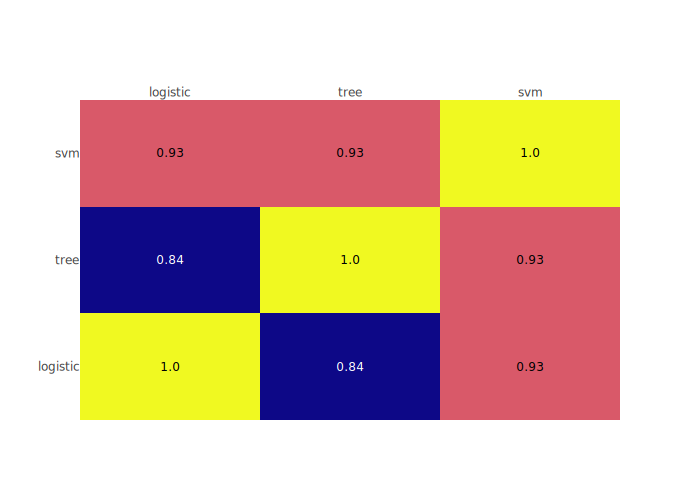

**The tree model is very correlated to the other ones. Let's drop it and see if it improves the performances.**

In [95]:
# Re-train by dropping the tree estimator because it's quite correlated with the other models
print('Training stacking regressor...')
stacking = StackingRegressor(estimators = [("liear", linreg), ("svm", svm)], cv = 3)
preds = stacking.fit_transform(X_train, y_train)
predictions = pd.DataFrame(preds, columns=stacking.named_estimators_.keys())
print('...Done.')
display(predictions)
print("R2 on training set : ", stacking.score(X_train, y_train))
print("R2 on test set : ", stacking.score(X_test, y_test))

Training stacking regressor...
...Done.


,liear,svm
0,2.300669,2.276903
1,1.544429,1.562031
2,1.875109,1.858982
3,1.845116,1.917563
4,1.954224,1.891437
...,...,...
3049,2.260247,2.260438
3050,1.977729,1.946846
3051,2.079157,2.043548
3052,1.954295,1.918914


R2 on training set :  0.9999979688383637
R2 on test set :  0.9999961818017714


Training stacking regressor...
...Done.


,liear,svm
0,1.984251,2.206880
1,1.861239,1.810204
2,1.917189,1.975256
3,1.861129,1.927074
4,1.938224,1.931660
...,...,...
3049,2.413910,2.283180
3050,1.982064,1.877633
3051,2.057843,2.060519
3052,2.000382,2.018037


R2 on training set :  0.8270313086077774
R2 on test set :  0.7168220752608871


The test R2 didn't change significantly, but the overfitting was a bit reduced.

The best model among all is still XGBoost, which happens quite often! XGBoost is known to give good results in Kaggle competitions. But the No Free Lunch theorem forces us to challenge XGBoost with other strategies because it's not guaranted that it will always outperform the other models !